# Introduction

## Load libraries

In [2]:
from fastai.vision.all import *
from fastcore.all import *
import kagglehub
import os

/Users/congho/SU_Homework/data-5100-foundations-of-data-science/classification/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Domain Problem

We want to develop a model to classify whether a person wear a safety vest shown in an image

## Safety Vest Classifier

The data are from the [Safety Vests Detection Dataset](https://www.kaggle.com/datasets/adilshamim8/safety-vests-detection-dataset/data)

In [3]:
os.environ["KAGGLEHUB_CACHE"] = "../data"
path = kagglehub.dataset_download("adilshamim8/safety-vests-detection-dataset")

print("Path to dataset files:", path)

100%|██████████| 406M/406M [00:16<00:00, 25.7MB/s] 

Extracting files...


Path to dataset files: ../data/datasets/adilshamim8/safety-vests-detection-dataset/versions/1


Look at few image

In [4]:
file_name = get_image_files('../data/datasets/adilshamim8/safety-vests-detection-dataset/versions/1/train/train')

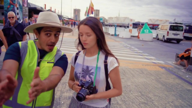

In [7]:
img = PILImage.create(file_name[25])

img.to_thumb(192)

## Data Processing